# Final Report: Comparative Analysis of Residential Home Sales in East Hartford and West Hartford



## Introduction

### Background Info
Different areas have different price distributions and variability which may be a crucial factor in someone’s plans for the next few years of their life. Therefore, understanding the housing market and real estate trends is very important when potential homebuyers want to make informed decisions before buying. There are many ways to be more informed, ranging from official legislature setting a bar for how professional agents better serve consumers with their needs and interests in mind, to personal research that one does on the side.

### Project Question
Is there a difference in mean sale price of residential properties in two different towns, East Hartford and West Hartford, segmented by residential type?

### Data Set
We will be using the Real Estate Sales 2001-2020 GL data set from the Data.gov data catalog. It contains records about real estate sales over $2,000 in the US state of Connecticut between the years of 2001 to 2020, including information about the year of listing, town, assessed value, sale amount, property type, and residential type. 


## Preliminary Results

First we wrangle the data and plot it before doing our preliminary analysis

In [6]:
# loading in libraries
library(tidyverse)
library(tidymodels)
library(janitor)
library(infer)
library(patchwork)
options(repr.plot.width = 8, repr.plot.height = 5) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Wrangling Dataset

In [7]:
# data set url
url <- "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"

# read data 
real_estate_data <- read_csv(url) |>
    clean_names()

head(real_estate_data)

Rows: 997213 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Date Recorded, Town, Address, Property Type, Residential Type, Non ...
dbl (5): Serial Number, List Year, Assessed Value, Sale Amount, Sales Ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


serial_number list_year date_recorded town    address              
1 2020348       2020      09/13/2021    Ansonia 230 WAKELEE AVE      
2   20002       2020      10/02/2020    Ashford 390 TURNPIKE RD      
3  200212       2020      03/09/2021    Avon    5 CHESTNUT DRIVE     
4  200243       2020      04/13/2021    Avon    111 NORTHINGTON DRIVE
5  200377       2020      07/02/2021    Avon    70 FAR HILLS DRIVE   
6  200109       2020      12/09/2020    Avon    57 FAR HILLS DRIVE   
  assessed_value sale_amount sales_ratio property_type residential_type
1 150500          325000     0.4630      Commercial    NA              
2 253000          430000     0.5883      Residential   Single Family   
3 130400          179900     0.7248      Residential   Condo           
4 619290          890000     0.6958      Residential   Single Family   
5 862330         1447500     0.5957      Residential   Single Family   
6 847520         1250000     0.6780      Residential   Single Family   
  non_use_code assessor_remarks opm_remarks location
1 NA           NA               NA          NA      
2 NA           NA               NA          NA      
3 NA           NA               NA          NA      
4 NA           NA               NA          NA      
5 NA           NA               NA          NA      
6 NA           NA               NA          NA

In [8]:
# keeping only relevant columns and filtering out houses sold before 2017 to decrease the effect of inflation
real_estate_selected <- real_estate_data |>
    select(town, list_year, assessed_value, sale_amount, residential_type) %>%
    filter(!is.na(list_year), !is.na(sale_amount), !is.na(residential_type), !is.na(town), !is.na(assessed_value), list_year >= 2017)
head(real_estate_selected)

# keeping only the two towns of interest
filtered_real_estate <- real_estate_selected %>%
    filter(town == "West Hartford" | town == "East Hartford")
head(filtered_real_estate)

town    list_year assessed_value sale_amount residential_type
1 Ashford 2020      253000          430000     Single Family   
2 Avon    2020      130400          179900     Condo           
3 Avon    2020      619290          890000     Single Family   
4 Avon    2020      862330         1447500     Single Family   
5 Avon    2020      847520         1250000     Single Family   
6 Berlin  2020      234200          130000     Two Family

town          list_year assessed_value sale_amount residential_type
1 West Hartford 2020      216580         305000      Single Family   
2 West Hartford 2020      181720         327900      Single Family   
3 West Hartford 2020      166670         305000      Condo           
4 East Hartford 2020       87380         235000      Single Family   
5 East Hartford 2020       73340         180000      Single Family   
6 East Hartford 2020       99730         164000      Single Family

In [13]:
# Looking at the number of homes sold in the two towns we are interested in
diff_town <- filtered_real_estate %>%
    group_by(town, residential_type) %>%
    summarize(n = n())
diff_town

`summarise()` has grouped output by 'town'. You can override using the
`.groups` argument.


town          residential_type n   
1  East Hartford Condo             314
2  East Hartford Four Family        33
3  East Hartford Single Family    2528
4  East Hartford Three Family       74
5  East Hartford Two Family        216
6  West Hartford Condo             747
7  West Hartford Four Family         3
8  West Hartford Single Family    3665
9  West Hartford Three Family       60
10 West Hartford Two Family        194

##### *Table 1:* Numerical summary of each town's residential types

From Table 1, since we see that three and four family houses are not very common, we will remove them from our sample as they may be skewed or not provide a lot of insight. The rest of the housing types were sold quite frequently in both towns and have a reasonably sized number number of housing sales, so we should not have to worry about outliers and can continue on with the data.

In [14]:
# calculating some summary statistics about the population
real_estate_final <- filtered_real_estate %>%
    filter(residential_type == "Condo" | residential_type == "Single Family" | residential_type == "Two Family")

stats <- real_estate_final %>%
    group_by(town, residential_type) %>%
    summarize(mean_sale_amount = mean(sale_amount), 
              min_sale_amount = min(sale_amount), 
              max_sale_amount = max(sale_amount), 
              mean_year = mean(list_year), 
              min_year = min(list_year), 
              max_year = max(list_year), 
              n = n())
#head(stats)

# Generating simpler statistics regardless of residential type for preliminary analysis
stats_simple <- real_estate_final %>%
    group_by(town) %>%
    summarize(mean_sale_amount = mean(sale_amount), median_year = median(list_year), n = n())

#head(stats_simple)

`summarise()` has grouped output by 'town'. You can override using the
`.groups` argument.


In [15]:
head(stats)

town          residential_type mean_sale_amount min_sale_amount
1 East Hartford Condo            124937.7          3000          
2 East Hartford Single Family    162864.7          1200          
3 East Hartford Two Family       180050.0         20000          
4 West Hartford Condo            234574.5          9000          
5 West Hartford Single Family    355614.3          5000          
6 West Hartford Two Family       340705.5         77500          
  max_sale_amount mean_year min_year max_year n   
1 4500000         2018.742  2017     2020      314
2  420000         2018.509  2017     2020     2528
3  355000         2018.579  2017     2020      216
4 1625000         2018.600  2017     2020      747
5 1700000         2018.604  2017     2020     3665
6  565000         2018.686  2017     2020      194

##### *Table 2:* Summary statistics

In [16]:
head(stats_simple)

town          mean_sale_amount median_year n   
1 East Hartford 160184.1         2019        3058
2 West Hartford 335356.1         2019        4606

##### *Table 3:* Simplified summary statistics

#### Making the relevant plots for East and West Hartford

In [17]:
# Making histogram of East Hartford
options(repr.plot.width=15, repr.plot.height=6)
east_data <- real_estate_final %>%
    filter(town == "East Hartford") 

east_plot <- east_data%>%
    ggplot() +
        geom_histogram(aes(x = sale_amount), bins = 10000, color = "green") +
        labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of East Hartford Sale Prices") +
        geom_vline(xintercept = 160184.1, colour="red") + 
        xlim(0, 1000000) + 
        theme(text = element_text(size = 12))

# Making histogram of West Hartford
west_data <- real_estate_final %>%
    filter(town == "West Hartford") 

west_plot <- west_data%>%
    ggplot() +
        geom_histogram(aes(x = sale_amount), bins = 10000, color = "blue") +
        labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of West Hartford Sale Prices") +
        geom_vline(xintercept = 335356.1, colour="red") + 
        xlim(0, 1000000) +
        theme(text = element_text(size = 12))

In [18]:
# separate the real_estate_final by residence types
single_family <- real_estate_final |>
    filter(residential_type == "Single Family")

two_family <- real_estate_final |>
    filter(residential_type == "Two Family") 

condo <- real_estate_final |>
    filter(residential_type == "Condo")

In [19]:
# making boxplots for each residential type
options(repr.plot.width=18, repr.plot.height=6)
single_family_boxplot <- single_family |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for single family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

two_family_boxplot <- two_family |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for two family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

condo_boxplot <- condo |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for condo housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

#### Displaying the plots

Warning message:
“Removed 2 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 29 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


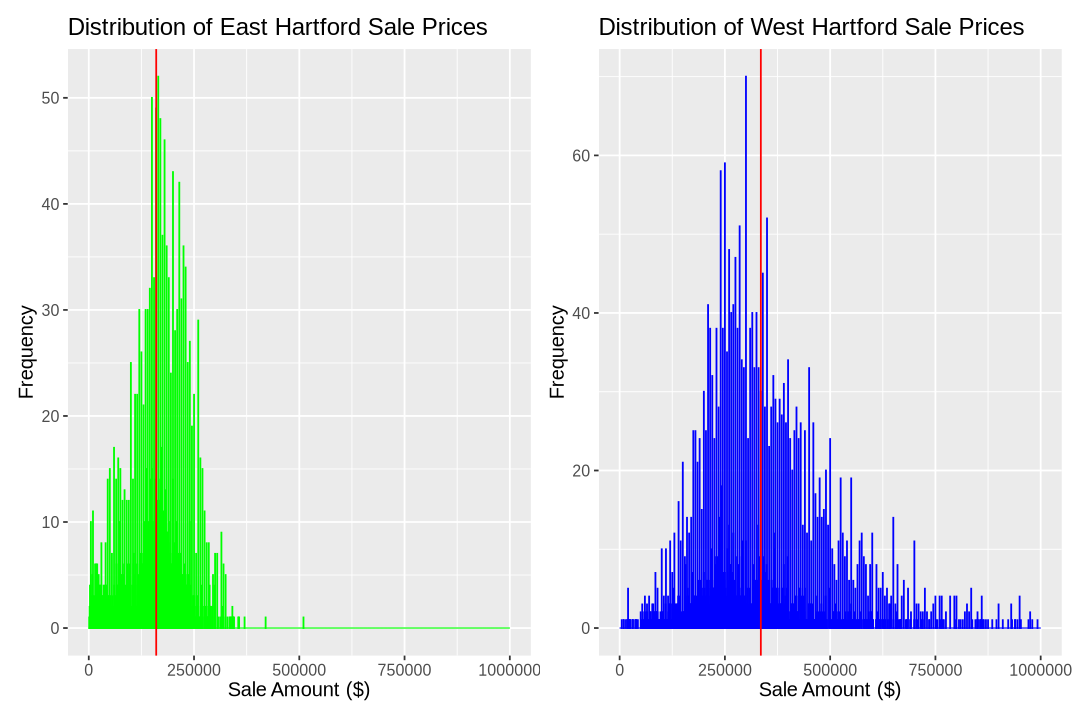

In [9]:
# Displaying the histograms
# Because of the kernal constantly dying when trying to run these cells, we are loading in a PNG of the histogram (this is the exact same histogram the code would of loaded)

# options(warn= -1)
(east_plot | west_plot)


##### *Figure 1:* Distributions of sale prices in East and West Hartford

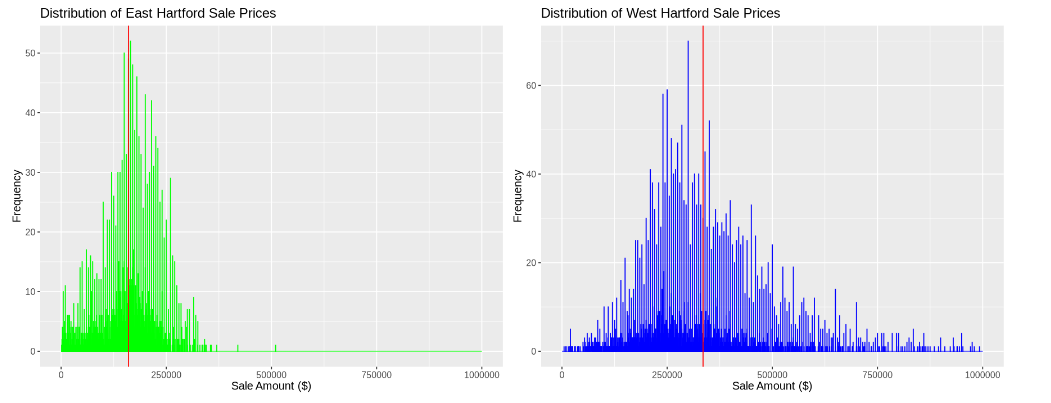

*(Including this image of Figure 1 in case the kernel dies and the previous code cell is unable to run. We were able to obtain this output with that same code cell but inconsistently.)*

### Distribution of West and East Hartford Sale Prices



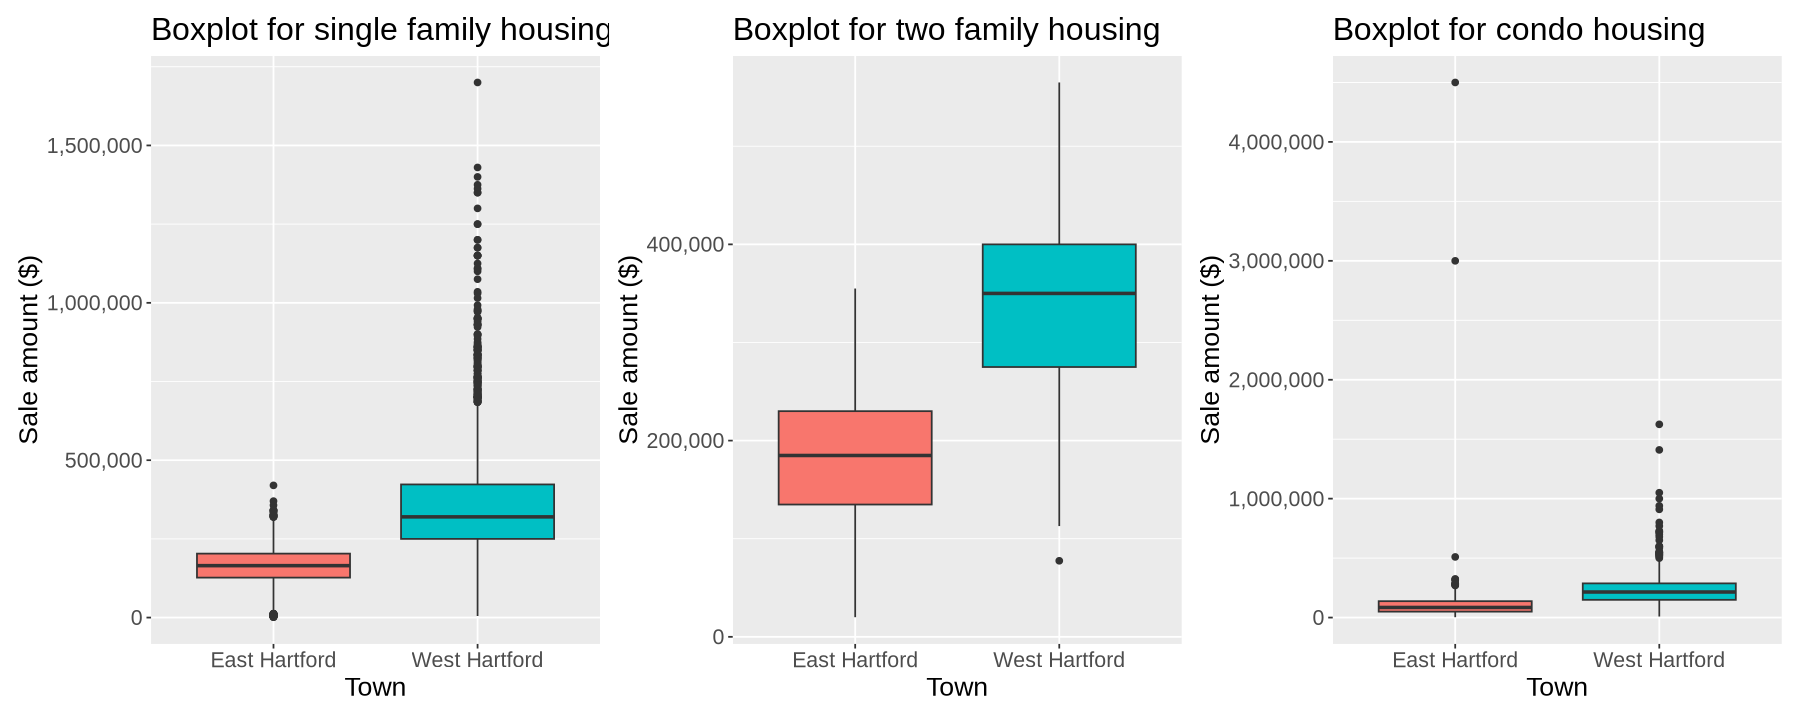

In [22]:
# Displaying the boxplots
options(repr.plot.width = 15)
(single_family_boxplot | two_family_boxplot | condo_boxplot)

##### *Figure 2:* Boxplots for each residential type in East and West Hartford

By looking at Figure 2, it is clear there are some outliers in our data when it comes to the sale price. To prevent this we will be filtering our sale amounts to get rid of sales that occur above $Q3 + 3*IQ$ and below $Q1 - 3*IQ$ for each respective housing type and then replotting it to get a better idea of how our data looks.

In [23]:
# Filtering out the outliers and making the new boxplots

options(repr.plot.width=18, repr.plot.height=6)
Q_single <- quantile(single_family$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_single <- IQR(single_family$sale_amount)
single_no_outlier <- subset(single_family, single_family$sale_amount > (Q_single[1]-1.5*iqr_single) & single_family$sale_amount < (Q_single[2]+1.5*iqr_single))

single_family_boxplot_no_outlier <- single_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for single family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

Q_two <- quantile(two_family$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_two <- IQR(two_family$sale_amount)
two_no_outlier <- subset(two_family, two_family$sale_amount > (Q_two[1]-1.5*iqr_two) & two_family$sale_amount < (Q_two[2]+1.5*iqr_two))

two_family_boxplot_no_outlier <- two_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for two family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

Q_condo <- quantile(condo$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_condo <- IQR(condo$sale_amount)
condo_no_outlier <- subset(condo, condo$sale_amount > (Q_condo[1]-1.5*iqr_condo) & condo$sale_amount < (Q_condo[2]+1.5*iqr_condo))

condo_boxplot_no_outlier <- condo_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for condo housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

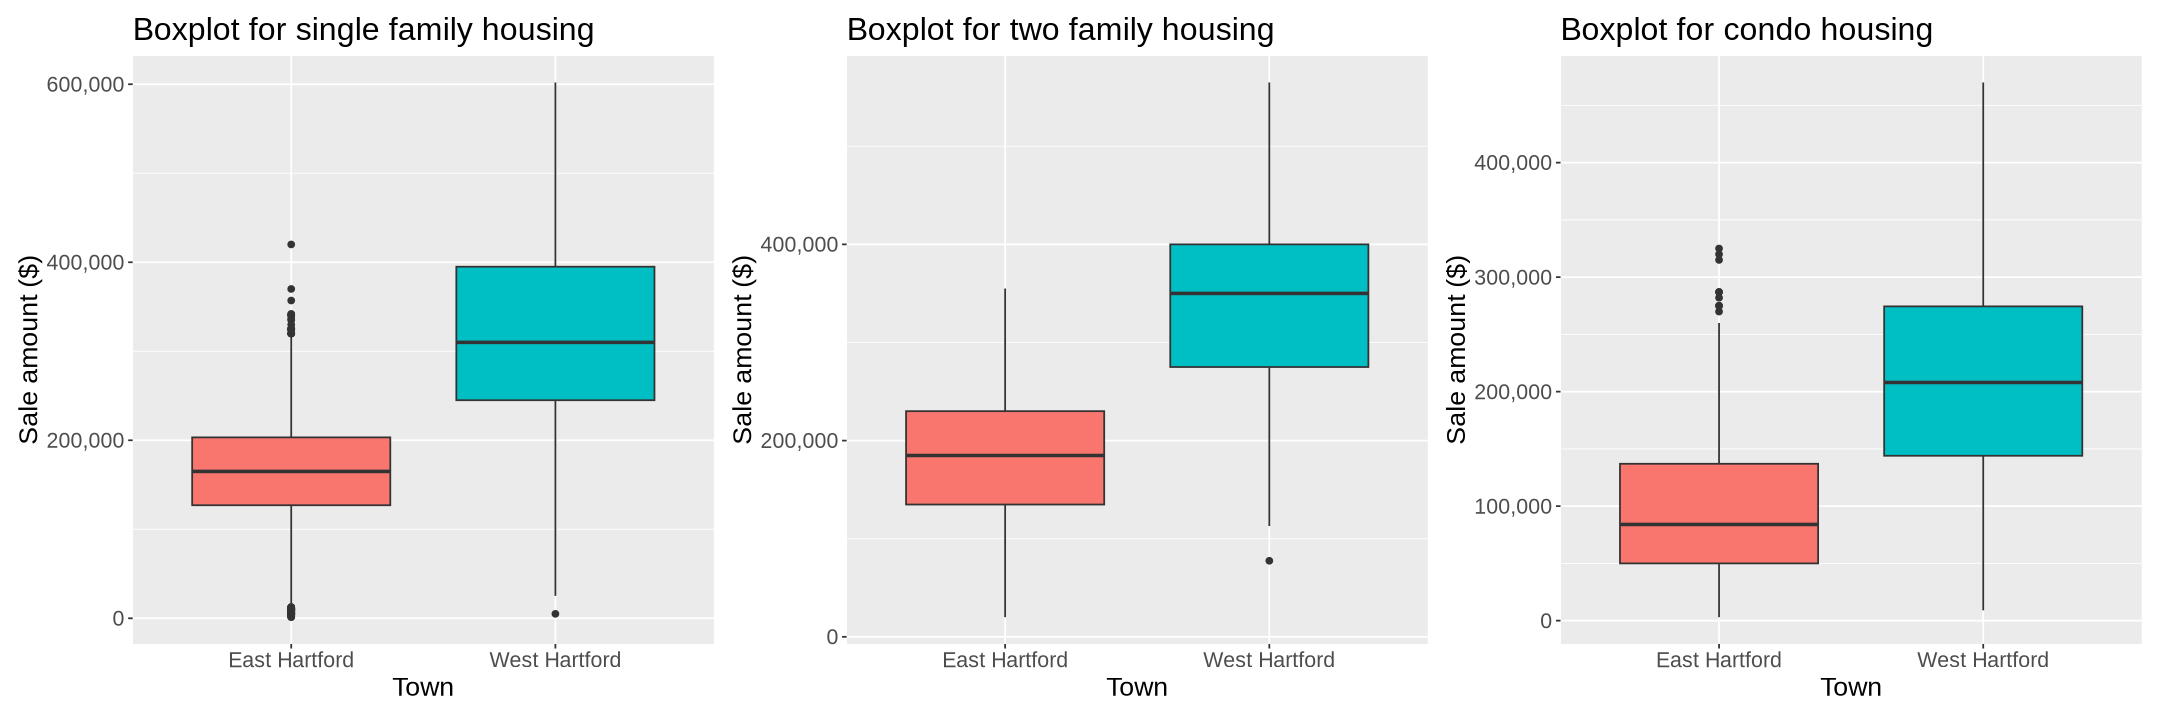

In [24]:
# Displaying the new boxplots with no outliers

(single_family_boxplot_no_outlier | two_family_boxplot_no_outlier | condo_boxplot_no_outlier)

##### *Figure 3:* Residential type boxplots with outliers removed

### Analysis of preliminary exploration
After looking at the mean sale price and plots for East and West Hartford, while we see that West Hartford does seem to have a higher mean, it may not be enough to immediately assume that West Hartford always has a higher mean in housing sales price. Especially when it comes to bigger numbers such as the amount of money required to buy a house, it is better to be statistically sure of your analysis rather than just taking a single snapshot as the whole picture for granted. Especially because we cannot be sure with the outliers that are in the sample.


## Methods and Results

Hypothesis: Since both East and West Hartford both reside within Hartford we expect the mean sale price of each half of the city to be the same. We will be testing this theory for the 3 most popular residential types of housing within Hartford: condos, single-family houses, and two-family houses. 

In other words: 
Let $S_E$ be the mean sales price of housing in East Hartford and let $S_w$ be the mean sales price of housing in West Hartford. Our null hypothesis is that these values are the same, which can be represented as $H_0: S_E - S_W = 0$ versus $H_A: S_E - S_W \neq 0$.

We will be testing our hypothesis at a $\alpha = 0.05$ significance level, which means if our $p$-value does not fall below 0.05, we would fail to reject $H_0$. The reason for picking such a low value of $\alpha$ is because just from our preliminary data exploratory analysis, we can already see West Hartford has on average a higher sale price. That way if we were to accept $H_0$ we would be more sure that we are unlikely to make a Type I error.

In order to calculate our $p$-value, we will use reshuffling to generate more copies of the sample in order to calculate P on. After generating our samples we will calculate the required summary statistics; in our case being the difference in meansales price. This gives us our null distribution which we can plot or directly use to calculate the $p$-value. This will be done using the `infer` package. After we get our $p$-value we can either reject or accept the null hypothesis depending if it's above or under our 0.05 significance level. After this we will obtain further insight into the relation between sale prices between West Hartford and East Hartford housing by obtaining a confidence interval through bootstrapping. 

Furthermore, we hope to compare theory based approaches with our bootstrapped approach, and so we will also conduct a two sample $t$-test. We will generate a sampling distribution and ensure we meet conditions to apply CLT. We will then be able to conduct our two sample $t$-test and compare the results obtained from this, to our results obtained from bootstrapping.

### Performing hypothesis testing via permutation

As seen above, our boxplot visualizes that East Hartford and West Hartford sale prices are different. To further investigate this we will now conduct our hypothesis test comparing mean sale prices.

$$H_0: S_E - S_W = 0$$

$$H_A: S_E - S_W \neq 0$$

In [25]:
# Firstly, we obtain our test statistic 
obs_diff_in_means <- real_estate_final |>
    specify(formula =  sale_amount ~ town) |>
    calculate(stat="diff in means", order = c("East Hartford", "West Hartford"))

obs_diff_in_means

stat   
1 -175172

In [ ]:
# Now let's create our null distribution
null_diff_in_means <- real_estate_final %>% 
    specify(formula = sale_amount ~ town) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("East Hartford", "West Hartford"))

# We will now visualize our null distribution with our test statistic
diff_in_means_plot <- null_diff_in_means %>%
    visualize(bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "both") + 
    xlab("Difference in means")

diff_in_means_plot

##### *Figure 4:*

From our plot, we observe that our test statistic is highly unlikely under the null hypothesis. This indicates we are likely to have a low $p$-value, very close to or equal to zero.

In [1]:
# And finally obtain the p-value
p_value <- null_diff_in_means |>
    get_p_value(obs_stat = obs_diff_in_means, direction = "both")

p_value

ERROR: Error in get_p_value(null_diff_in_means, obs_stat = obs_diff_in_means, : could not find function "get_p_value"


From our visulization we saw that our test statistic is very unlikely under the null model. This unlikelihood is further conveyed by our low $p$-value, which prompts us to reject the our null hypothesis, that there is no difference between mean sale prices of properties in East Hartford and West Hartford at a 5% significance level. Rejecting the null hypothesis puts us at risk of committing Type I error. After rejecting the null hypothesis, a Type I error would occur if and only if the true difference of between mean sale amounts in East Hartford and West Hartford is zero.

Now let's create a 95% confidence interval for the true difference in mean sale prices between East Hartford and West Hartford.

### Obtaining a 95% confidence interval (Bootstrap approach)

In [2]:
# obtain 95% confidence interval using bootstrapping
diff_in_means_bootstrap_dist <- real_estate_final |>
    specify(formula = sale_amount ~ town) |>
    generate(type = "bootstrap", reps = 1000) |>
    calculate(stat = "diff in means", order = c("East Hartford", "West Hartford"))

diff_in_means_ci <- diff_in_means_bootstrap_dist |>
    get_confidence_interval( level = 0.95, type = "percentile")

diff_in_means_ci

ERROR: Error in calculate(generate(specify(real_estate_final, formula = sale_amount ~ : could not find function "calculate"


##### *Table 4:*

From our bootstrapped confidence interval, we are 95% confident that the true difference in mean sale prices between East Hartford and West Hartford is between -181117.4 and -168796.8.

### Two sample $t$-test

Let's now compare the bootstrap results to a theory-based approach. For our theory-based approach, we will be conducting a two sample $t$-test, which we do by applying the Central Limit Theorem. We can apply CLT as we have a large enough sample size ($n = 60$), our sample is randomly drawn from the population, and our sample values are independent.

In [15]:
# We will be conducting our t test using t.test from the tidy package
sampling_dist_means <- real_estate_final |>
    rep_sample_n(reps = 10000, size = 60) |>
    group_by(replicate) |>
    summarise(town = town,
              sale_mean = mean(sale_amount))

east <- sampling_dist_means |>
    filter(town == "East Hartford")

west <- sampling_dist_means |>
    filter(town == "West Hartford")

t_test <- 
    tidy(
        t.test(x = east$sale_mean,
               y = west$sale_mean,
               alternative = "two.sided")) 

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


In [16]:
# Let's obtain our p-value from our t-test
t_test$p.value

[1] 0

We observe that our $p$-value obtained from our $t$-test is the same as the p value obtained earlier. Now let's compare our confidence intervals.

In [17]:
confidence_interval <- data.frame(ci_lower = t_test$conf.low, ci_upper = t_test$conf.high)
confidence_interval

ci_lower  ci_upper 
1 -2999.741 -2773.517

##### *Table 5:*

From our $t$-test confidence interval, we are 95% confident that the true difference in means is between -2999.741 and - 2773.517. Our 95% confidence intervals are quite different, observing that the $t$-test results in a narrower interval. This could be a result of our original sample size in our bootstrapping approach, as we were generating bootstrap samples from such a large sample, thus making sense that there is greater variability between bootstrap samples. Hence, the confidence interval with the bootstrap approach was wider.

In context of our question, it appears the $t$-test is better than the other approach as its confidence interval is much narrower, implying that it is "more confident". However applying CLT is not very efficent as it required us to generate the sampling distribution, which is not always plausible in real life. Furthermore, using CLT requires assumption of our data, whereas bootstrapping does not. However, from our results we can observe how much our values were influenced by our original sample in bootstrapping. This could be an major issue in bootstrapping. If an original sample is not representative of the actual population, then bootstrapping will provide inaccurate results. 

Overall, we believe both methods are equally as trustworthy in the right situations. However we have that one method may be 'better' than the other in different contexes.

## Discussion

**What do you expect to find?**

- We had expected to find that there was generally no difference in the mean sale price between the two towns. Based on our analysis, we rejected this conclusion as our null hypothesis did not hold with a $p$-value of 0. Rejecting our null hypothesis places us at risk of committing Type I error where it could turn out that there truly is no difference in the mean sale price of residences between East Hartford and West Hartford.

**What impact could such findings have?**

- The impact of our findings could be insight into how a homebuyer should consider different areas to buy a home in, potentially researching other factors such as community services and accessibility rather than focusing on price. On a larger scale, our analysis shows how the housing market is not straightforward and how there are many other factors that could play into homebuyers' decisions. Price plays a major role, but even geographical location (or proximity) does not guaranteed the same conditions for the market at a specific point in time.

**What future questions could this lead to?**

- What other factors influence the difference in real estate markets between two towns that are in close geographical proximity to one another? Social, economic, and infrastructure-related factors are other contributors to take into account with the real estate market, with each possibility capable of branching out into more ways that it impacts the state of housing in a specific location. It then follows that such findings might also suggest investigations into whether or not certain factors influence the market the same way between towns that are similar in nature but distant in proximity, exploring how transferable the findings are and how the conclusions can be applied.

## References

Real Estate Sales 2001-2020 GL. data.ct.gov, 9 Aug. 2023. Data.gov, 

    https://catalog.data.gov/dataset/real-estate-sales-2001-2018.
Real Estate Agents As a Source of Information for Home Buyers - HOUSTON - 1977 - Journal of Consumer Affairs - Wiley Online Library. 

    https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-6606.1977.tb00600.x. 
    
    Accessed 4 Nov. 2023.
    
Harnaga, Brandon J. Another Housing Bubble? A Review of Historical Indicators and Analysis of the Current State of the U.S. Residential Real Estate Market. May 2021. soar.suny.edu, 
    
    https://soar.suny.edu/handle/20.500.12648/1885.
